## People Detection

In [1]:
# Clone RAPiD-T respository for top view people detection
!git clone https://github.com/ozantezcan/RAPiD-T.git

Cloning into 'RAPiD-T'...
remote: Enumerating objects: 398, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 398 (delta 103), reused 68 (delta 68), pack-reused 282
Receiving objects: 100% (398/398), 9.30 MiB | 27.60 MiB/s, done.
Resolving deltas: 100% (217/217), done.


In [2]:
# Check GPU availability
import torch

if torch.cuda.is_available():
    # If a GPU is available, set the device to GPU
    device = torch.device("cuda")
    print("GPU is available")
else:
    # If a GPU is not available, set the device to CPU
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available


In [3]:
# Set Matplotlib Backend
%matplotlib inline

# Set Autoreload Extension
%load_ext autoreload
%autoreload 2

# Set Working Directory
import os
os.chdir("/content/RAPiD-T")

# Import Libraries
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import glob
import json
import time

# Import Custom Modules
from api import Detector
from utils import visualization
from utils import vid_utils as vid
from utils import repp_rotated_api as repp

In [4]:
# Download Weight File
import gdown

# Set the Google Drive file ID
file_id = '10C4KQpS1wKeKGrT0_AL9d6dYb42hlI-L'

# Set the destination path to save the downloaded file
destination_path = os.path.join('weights', 'RAPiD.ckpt')

# Download the file from Google Drive
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, destination_path)

Downloading...
From: https://drive.google.com/uc?id=10C4KQpS1wKeKGrT0_AL9d6dYb42hlI-L
To: /content/RAPiD-T/weights/RAPiD.ckpt
100%|██████████| 291M/291M [00:02<00:00, 120MB/s]


'weights/RAPiD.ckpt'

In [5]:
# Download Weight Configuration File
import gdown

# Set the Google Drive file ID
file_id = '1VpMCGI0K92dkBozhPXOj10tF4IlsJxBU'

# Set the destination path to save the downloaded file
destination_path = os.path.join('weights', 'matching_model_logreg_cepdof_dist5.pckl')

# Download the file from Google Drive
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, destination_path)

Downloading...
From: https://drive.google.com/uc?id=1VpMCGI0K92dkBozhPXOj10tF4IlsJxBU
To: /content/RAPiD-T/weights/matching_model_logreg_cepdof_dist5.pckl
100%|██████████| 979/979 [00:00<00:00, 4.63MB/s]


'weights/matching_model_logreg_cepdof_dist5.pckl'

In [6]:
# Set Paths and Directories
weights_path = "weights/RAPiD.ckpt"
in_path = "examples"
out_path = "outputs/RAPiD_REPP"
os.makedirs(out_path, exist_ok=True)
flow_warping = False

# Initialize Detector Model
# detector = Detector(model_name='rapid', weights_path=weights_path)

# Load Bounding Box Association Model of REPP
repp_cfg = "utils/cepdof_repp_cfg.json"
repp_params = json.load(open(repp_cfg, 'r'))
repp_model = repp.REPP(**repp_params)

Loading clf matching model: ./weights/matching_model_logreg_cepdof_dist5.pckl


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
# Extract Frames from video clip
import os
import cv2

# Path to the input video file
video_path = '/content/sample.mp4'

# Extract the video name without extension
video_name = os.path.splitext(os.path.basename(video_path))[0]

# Open the video file
video = cv2.VideoCapture(video_path)

# Create a directory to save the frames
frame_output_directory = f'{in_path}/{video_name}'
os.makedirs(frame_output_directory, exist_ok=True)

# Initialize variables
frame_count = 1

# Read frames from the video
while True:
    # Read the next frame
    ret, frame = video.read()

    # Break the loop if there are no more frames
    if not ret:
        break

    # Generate the output filename
    output_framename = f"{video_name}_{frame_count:06d}.png"
    frame_output_path = os.path.join(frame_output_directory, output_framename)

    # Save the frame as an image file
    cv2.imwrite(frame_output_path, frame)

    # Increment the frame count
    frame_count += 1

# Release the video file
video.release()

In [8]:
# Set video name to detect
video_names_detect = [video_name]

In [10]:
# Unpickle the detection results from the Files
import pickle

# Unpickle dets_repp
with open('/content/dets_repp.pkl', 'rb') as file:
    dets_repp = pickle.load(file)

# Unpickle dets_arr
with open('/content/dets_arr.pkl', 'rb') as file:
    dets_arr = pickle.load(file)

# Unpickle dets_dict
with open('/content/dets_dict.pkl', 'rb') as file:
    dets_dict = pickle.load(file)


In [11]:
vid_conf = 0.3

# Create directories
os.makedirs(os.path.join(out_path, "txts"), exist_ok=True)
os.makedirs(os.path.join(out_path, "jsons"), exist_ok=True)
os.makedirs(os.path.join(out_path, f"vids/conf{vid_conf}"), exist_ok=True)

# Process videos
for vid_name in video_names_detect:
    print(f"Processing {vid_name}")
    vid_folder = os.path.join(in_path, vid_name)
    txt_det_folder = os.path.join(out_path, "txts", vid_name)
    json_det_path = os.path.join(out_path, "jsons", f"{vid_name}_dets.json")

    # Compute detections
    print("Computing detections...")
    tic = time.perf_counter()
    # vid.saveDets(
    #     detector,
    #     vid_folder,
    #     txt_det_folder,
    # )

    # Convert detections from txt to json
    # dets_arr = vid.txt2json(txt_det_folder, save_as_json=False)

    # REPP post-processing
    print("Post-processing with REPP...")
    # dets_dict = repp.det_arr_to_det_dict(dets_arr,root_dir_frames='/content/RAPiD-T/examples')
    # dets_repp = repp_model(dets_dict)
    json.dump(dets_repp, open(json_det_path, 'w'), indent=4)
    toc = time.perf_counter()
    elapsed = toc - tic
    num_frames = len(os.listdir(vid_folder))
    fps = num_frames / elapsed
    print(f"Computed detections of {num_frames} frames in {elapsed:0.4f} seconds: {fps:0.4f} FPS")

    # Produce a video of detections
    print("Creating video...")
    im2dets = vid.json2dict(json_det_path)
    im2dets_arr = [(im2dets, (0, 255, 0), False, vid_conf)]
    vid_path = os.path.join(out_path, f"vids/conf{vid_conf}", f"{vid_name}_dets.mp4")
    vid.saveVideo(vid_folder, im2dets_arr, vid_path)

print("DONE!")

Processing sample
Computing detections...
Post-processing with REPP...
Computed detections of 1341 frames in 0.2627 seconds: 5104.3559 FPS
Creating video...
DONE!


In [ ]:
# # Pickle the detection results
# import pickle

# # Pickle dets_arr
# with open('dets_arr.pkl', 'wb') as file:
#     pickle.dump(dets_arr, file)

# # Pickle dets_repp
# with open('dets_repp.pkl', 'wb') as file:
#     pickle.dump(dets_repp, file)

# # Pickle dets_dict
# with open('dets_dict.pkl', 'wb') as file:
#     pickle.dump(dets_dict, file)

In [ ]:
# Access dets_arr
print(dets_arr[:5])

[{'image_id': 'sample_000001', 'bbox': [273.79705811, 186.10665894, 74.75085449, 110.16432953, -12.00547791], 'score': 0.86502004, 'segmentation': []}, {'image_id': 'sample_000001', 'bbox': [234.7376709, 97.52936554, 63.04268265, 93.77900696, 91.55895996], 'score': 0.60139126, 'segmentation': []}, {'image_id': 'sample_000001', 'bbox': [185.24234009, 124.45947266, 63.88580704, 89.62056732, -21.63174438], 'score': 0.57365412, 'segmentation': []}, {'image_id': 'sample_000001', 'bbox': [739.34631348, 200.67448425, 78.90244293, 98.00880432, 46.91586304], 'score': 0.41085798, 'segmentation': []}, {'image_id': 'sample_000001', 'bbox': [572.12750244, 24.49600601, 32.74517441, 44.16998291, -13.18643188], 'score': 0.34200478, 'segmentation': []}]


In [ ]:
# Access dets_dict
first_frame = dets_dict[next(iter(dets_dict))]
print(first_frame)

[{'image_id': 'sample_000001', 'bbox': [236.42163086500003, 131.02449417499997, 74.75085449, 110.16432953, -12.00547791], 'bbox_center': [0.28520526886458336, 0.25848147075], 'scores': array([0.72561316])}, {'image_id': 'sample_000001', 'bbox': [203.216329575, 50.63986206, 63.04268265, 93.77900696, -88.44104004], 'bbox_center': [0.2445184071875, 0.13545745213888888], 'scores': array([0.48992308])}, {'image_id': 'sample_000001', 'bbox': [153.29943657, 79.649189, 63.88580704, 89.62056732, -21.63174438], 'bbox_center': [0.19296077092708333, 0.17286037869444446], 'scores': array([0.67651496])}, {'image_id': 'sample_000001', 'bbox': [699.895092015, 151.67008209, 78.90244293, 98.00880432, 46.91586304], 'bbox_center': [0.770152409875, 0.27871456145833334], 'scores': array([0.57457844])}, {'image_id': 'sample_000001', 'bbox': [555.754915235, 2.4110145549999977, 32.74517441, 44.16998291, -13.18643188], 'bbox_center': [0.595966148375, 0.034022230569444444], 'scores': array([0.39506643])}, {'imag

In [ ]:
# Access dets_repp
print(dets_repp[:5])

[{'image_id': 'sample_000001', 'bbox': [572.12750244, 24.49600601, 32.74517441, 44.16998291, -13.18643188], 'score': 0.39506643277777775, 'segmentation': [], 'track_id': 0}, {'image_id': 'sample_000002', 'bbox': [572.30090332, 24.42091942, 33.02849579, 44.16041565, -13.53503418], 'score': 0.39506643277777775, 'segmentation': [], 'track_id': 0}, {'image_id': 'sample_000003', 'bbox': [572.43005371, 24.85772705, 33.35123062, 44.35451126, -14.49906921], 'score': 0.39506643277777775, 'segmentation': [], 'track_id': 0}, {'image_id': 'sample_000004', 'bbox': [573.47406006, 25.32246971, 33.52073669, 45.4034729, -12.83825684], 'score': 0.39506643277777775, 'segmentation': [], 'track_id': 0}, {'image_id': 'sample_000005', 'bbox': [573.48950195, 25.42821312, 33.59351349, 45.73729706, -12.49168396], 'score': 0.39506643277777775, 'segmentation': [], 'track_id': 0}]


In [ ]:
# Access im2dets
first_frame = im2dets['sample_000001']
for blob in first_frame:
  print(blob)

[ 5.72127502e+02  2.44960060e+01  3.27451744e+01  4.41699829e+01
 -1.31864319e+01  3.95066433e-01]
[273.79705811 186.10665894  74.75085449 110.16432953 -12.00547791
   0.72561316]
[185.24234009 124.45947266  63.88580704  89.62056732 -21.63174438
   0.67651496]
[234.7376709   97.52936554  63.04268265  93.77900696 -88.44104004
   0.48992308]
[7.39346313e+02 2.00674484e+02 7.89024429e+01 9.80088043e+01
 4.69158630e+01 5.74578438e-01]


## ROI Filtration

In [12]:
# Convert detection result into dictionary with IDs
''' key= frame_id
    value= [x,y,w,h,a,score,track_id]) '''

def json2dictwithids (json_path, include_ids=True):
    with open(json_path) as f:
        detections = json.load(f)

    if "annotations" in detections:
        detections = detections["annotations"]

    im2detswithids = {}
    for det in detections:
        image_id = det['image_id']
        bbox = det['bbox'].copy()
        score = det['score'] if 'score' in det else 0.0
        bbox.append(score)
        if include_ids:
            assert 'person_id' in det or 'track_id' in det
            if 'person_id' in det:
                bbox.append(det['person_id'])
            elif 'track_id' in det:
                bbox.append(det['track_id'])
        bbox = np.asarray(bbox)
        if image_id in im2detswithids:
            im2detswithids[image_id].append(bbox)
        else:
            im2detswithids[image_id] = [bbox]

    return im2detswithids

im2detsids = json2dictwithids(json_det_path)

In [13]:
# Access im2detsids (value= [x,y,w,h,a,score,track_id]
first_frame = im2detsids['sample_001341']
for blob in first_frame:
  print(blob)

[7.22906555e+02 6.26864807e+02 5.35893288e+01 6.12247734e+01
 1.54465027e+01 4.75893932e-01 8.43000000e+02]
[7.34682678e+02 3.52833557e+02 9.41006622e+01 1.24513947e+02
 8.00172119e+01 6.89863760e-01 8.48000000e+02]
[2.90869080e+02 1.16701126e+02 7.75704040e+01 9.53975601e+01
 4.65503540e+01 6.85683189e-01 8.51000000e+02]
[ 5.95916443e+02  6.86283020e+02  5.78484497e+01  6.75220871e+01
 -8.31721497e+00  5.57896336e-01  8.54000000e+02]
[2.62843994e+02 6.25418457e+02 7.64635696e+01 1.10201775e+02
 3.33659515e+01 3.70580805e-01 8.55000000e+02]
[ 3.37200592e+02  1.57496307e+02  6.46712570e+01  8.29854202e+01
 -1.51859283e+01  4.85693308e-01  8.58000000e+02]
[ 7.56066589e+02  4.61597961e+02  4.38941688e+01  8.34939270e+01
 -8.01041870e+01  3.25661020e-01  8.63000000e+02]
[ 2.50876694e+02  1.71599442e+02  6.63041992e+01  8.92819595e+01
 -3.62071838e+01  5.04521920e-01  8.64000000e+02]


In [14]:
# Extract ROI based on detection result
from google.colab.patches import cv2_imshow

def extract_roi(im, x, y, w, h, angle):
    '''
    im: image numpy array, shape(h, w, 3), RGB
    angle: degree
    '''
    c, s = np.cos(angle/180*np.pi), np.sin(angle/180*np.pi)
    R = np.asarray([[c, s], [-s, c]])
    pts = np.asarray([[-w/2, -h/2], [w/2, -h/2], [w/2, h/2], [-w/2, h/2]])
    rot_pts = []
    for pt in pts:
        rot_pts.append(([x, y] + pt @ R).astype(int))
    contours = np.array([rot_pts[0], rot_pts[1], rot_pts[2], rot_pts[3]])
    # Create a blank mask of the same size as the image
    mask = np.zeros_like(im)
    # Draw the contours on the mask
    cv2.fillPoly(mask, [contours], (255, 255, 255))
    # Bitwise AND operation to extract the ROI
    roi = cv2.bitwise_and(im, mask)
    return roi

In [15]:
# Find and filter contours
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_nametag(roi,width,height,center_x,center_y):
    '''
    roi: image numpy array of the region of interest (BGR format)
    width, height: width and height of the region of interest
    center_x, center_y: coordinates of the center of the region of interest
    '''

    # Convert the ROI to the HSV color space
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    #cv2_imshow(hsv_roi)

    # Define the lower and upper thresholds for the nametag color
    white_lower_threshold = np.array([80, 0, 100])
    white_upper_threshold = np.array([110, 50, 200])

    black_lower_threshold = np.array([80, 150, 50])
    black_upper_threshold = np.array([110, 250, 100])

    # Apply color thresholding to extract the nametag
    white_nametag_mask = cv2.inRange(hsv_roi, white_lower_threshold, white_upper_threshold)
    black_nametag_mask = cv2.inRange(hsv_roi, black_lower_threshold, black_upper_threshold)

    # Apply the logical OR operation
    nametag_mask = cv2.bitwise_or(white_nametag_mask, black_nametag_mask)

    # Apply morphological operations to improve the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    nametag_mask = cv2.morphologyEx(nametag_mask, cv2.MORPH_CLOSE, kernel)
    # cv2_imshow(nametag_mask)

    # Find contours of the nametag
    contours, _ = cv2.findContours(nametag_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and identify the nametag contours
    nametag_contours = []
    for contour in contours:
        contour_area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        roi_area = (width*height)*0.20
        roi_width = width*0.25
        roi_height = height*0.25
        perimeter = cv2.arcLength(contour,True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        poly = len(approx)

        if contour_area > 6 and contour_area < 70 and w>5 and w<20 and h>2 and h<8 and aspect_ratio>1.60 and aspect_ratio<3 and w<=roi_width and h<=roi_height and (center_x-roi_width)<x and (center_x+roi_width)>x and (center_y+roi_height)>y and (center_y-roi_height)<y and perimeter>5 and perimeter <42 and poly>9 and poly<13:
            nametag_contours.append(contour)

    return nametag_contours

In [16]:
# Compare the histograms using the correlation method
def compare_histograms(hist1, hist2):
    similarity = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return similarity

In [19]:
# Load reference histogram
with open('/content/reference_hist.pkl', 'rb') as file:
    reference_hist = pickle.load(file)

In [20]:
# Extract roi and find contours of the frame
directory = '/content/RAPiD-T/examples/sample'
tag_directory = '/content/ROI'
os.makedirs(tag_directory, exist_ok=True)
hists=[]

for frame in os.listdir(directory):
  if frame.endswith(('.jpg', '.jpeg', '.png')):
    frame_path = os.path.join(directory, frame)
    frame_name = os.path.splitext(frame)[0]
    # print(frame_name)
    curr_frame = cv2.imread(frame_path)
    dects = im2detsids.get(frame_name,[])

    for dect in dects:
      x, y, w, h, angle, score, id = dect
      x, y, w, h, angle= map(int, dect[:5])

      roi_ppl = extract_roi(curr_frame, x, y, w, h, angle)
      nametag_contours = detect_nametag(roi_ppl,w,h,x,y)
      contours_count = len(nametag_contours)

      if contours_count >=1:

        # # Display the contour
        # mask = np.zeros_like(curr_frame)
        # # Draw the nametag contours on the ROI image for visualization
        # cv2.drawContours(mask, nametag_contours, -1, (255, 255, 255), thickness=cv2.FILLED)
        # # Define a kernel for dilation
        # kernel = np.ones((30, 30), np.uint8)
        # # Perform dilation to enhance the area of the contours
        # enhanced_mask = cv2.dilate(mask, kernel, iterations=1)
        # # Apply the enhanced mask to the original image
        # result = cv2.bitwise_and(curr_frame, enhanced_mask)
        # # Display the result
        # cv2_imshow(result)

        for contour in nametag_contours:
          x, y, w, h = cv2.boundingRect(contour)

          # Extract the contours and compare its histogram with reference histogram
          roi = curr_frame[y:y+h, x:x+w]
          hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
          hist = cv2.calcHist([hsv_roi], [1,2], None, [128]*2, [0, 128]*2)
          similarity = compare_histograms(hist,np.array(reference_hist))

          if similarity <= (-0.001) or similarity>=0.9:
              idstr = str(id)
              idstr = idstr.split('.')[0]
              tag_filename = f"{frame_name}_{idstr}.png"
              tag_path = os.path.join(tag_directory, tag_filename)
              cv2.imwrite(tag_path, roi_ppl)

## Creating Video

In [22]:
# Convert detected roi with nametag to dictionary (key:frame id value=track id)
import os

# Specify the path to the directory
tag_directory = "/content/ROI"

# Get the list of files in the directory
files = os.listdir(tag_directory)

# Build the dictionary based on file names
id_dict = {}
for filename in files:
    # Extract the file name without the extension
    name = os.path.splitext(filename)[0]
    frame_id= name.split("_")
    frame_name=frame_id[1]
    id=frame_id[-1]

    # Add the file name to the dictionary
    if frame_name in id_dict:
      id_dict[frame_name].append(id)
    else:
      id_dict[frame_name] = [id]

# Print the dictionary
print(id_dict)

{'000929': ['578'], '000411': ['261'], '001121': ['685'], '000097': ['69'], '001228': ['777'], '000782': ['480'], '000973': ['598'], '000330': ['197'], '000327': ['197'], '001157': ['720'], '000974': ['598'], '000662': ['437'], '000537': ['345'], '001285': ['781'], '001333': ['848'], '001158': ['720'], '001296': ['808'], '000631': ['397'], '001246': ['690'], '000895': ['554'], '001062': ['658'], '001019': ['627'], '001067': ['568'], '001014': ['627'], '000813': ['452'], '001338': ['848'], '000444': ['299', '179'], '000806': ['480'], '000590': ['337'], '000976': ['598'], '000494': ['324'], '000414': ['283'], '000894': ['554'], '001066': ['568'], '000781': ['480'], '000708': ['458'], '001061': ['658'], '000640': ['419'], '000525': ['337'], '000413': ['283'], '000526': ['352', '357'], '001060': ['658'], '000617': ['337'], '000509': ['343'], '001130': ['674'], '001221': ['746'], '000726': ['462'], '000812': ['452'], '000454': ['306'], '001063': ['658'], '000497': ['257'], '000379': ['254']

In [23]:
# Create video by drawing the bounding box around detection results
def saveVideo(vid_folder, im2boxes_arr, out_path, img_ext=".png", show_count=False, show_id=False, fps=24, out_size=None):
    frames = set()
    for im2boxes, _, _, _ in im2boxes_arr:
        frames = frames.union(set(im2boxes.keys()))
    frames = sorted(list(frames))
    if out_size is None:
        image_path = os.path.join(vid_folder, f"{frames[0]}{img_ext}")
        img = Image.open(image_path)
        np_img = np.array(img)
        h, w, _ = np_img.shape
    else:
        w, h = out_size
        ratio = h / w

    vid = cv2.VideoWriter(
        out_path, cv2.VideoWriter_fourcc(*'MP4V'), fps, (w, h))

    for frame in frames:
        image_path = os.path.join(vid_folder, f"{frame}{img_ext}")
        if not os.path.exists(image_path):
            print(f"{image_path} does not exist")
            continue

        img = Image.open(image_path)
        np_img = np.array(img)
        for im2boxes, color, show_conf, conf_thres in im2boxes_arr:
            if frame in im2boxes and im2boxes[frame]:
                bbox = im2boxes[frame]
                draw_dt_on_np(
                    np_img, bbox, conf_thres=conf_thres, color=color, show_coor=True,
                    show_count=show_count, show_id=show_id)

        if out_size is not None:
            h_im, w_im, c_im = np_img.shape
            if h_im < (w_im * ratio):
                pad = int(((w_im * ratio)- h_im) / 2)
                np_img = cv2.copyMakeBorder(np_img, pad, pad, 0, 0, cv2.BORDER_CONSTANT, None, (0, 0, 0))
            if w_im < (h_im / ratio):
                pad = int(((h_im / ratio) - w_im) / 2)
                np_img = cv2.copyMakeBorder(np_img, 0, 0, pad, pad, cv2.BORDER_CONSTANT, None, (0, 0, 0))
        vid.write(cv2.resize(np_img[:, :, ::-1], (w, h)))

    vid.release()

In [24]:
# Draw the bounding box
def draw_dt_on_np(im, detections, print_dt=False, color=(255,0,0),
                  conf_thres=0.0, text_size=0.5, **kwargs):
    '''
    im: image numpy array, shape(h,w,3), RGB
    detections: rows of [x,y,w,h,a,conf], angle in degree
    '''
    line_width = kwargs.get('line_width', im.shape[0] // 300)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_bold = max(int(2*text_size), 1)
    person_count = 0
    for bb in detections:
        if len(bb) == 6:
            x,y,w,h,a,conf = bb
        else:
            x,y,w,h,a = bb[:5]
            conf = -1
        if conf >= conf_thres:
            x1, y1 = x - w/2, y - h/2
            if print_dt:
                print(f'[{x} {y} {w} {h} {a}], confidence: {conf}')
            visualization.draw_xywha(im, x, y, w, h, a, color=color, linewidth=line_width)
            person_count += 1
            if kwargs.get('show_coor', True):
                cv2.putText(im, f'{x:.0f},{y:.0f}', (int(x1),int(y1)), font, 1*text_size,
                            (255,255,255), font_bold, cv2.LINE_AA)
            if kwargs.get('show_angle', False):
                cv2.putText(im, f'{int(a)}', (x,y), font, 1*text_size,
                            (255,255,255), font_bold, cv2.LINE_AA)
    if kwargs.get('show_count', True):
        caption_w = int(im.shape[0] / 4.8)
        caption_h = im.shape[0] // 25
        start = (im.shape[1] - caption_w, im.shape[0] // 20)
        end = (im.shape[1], start[1] + caption_h)
        cv2.putText(im, f'Count: {person_count}',
                    (im.shape[1] - caption_w + im.shape[0]//100, end[1]-im.shape[1]//200),
                    font, 1.2*text_size,
                    (255,255,255), font_bold*2, cv2.LINE_AA)

In [25]:
# Create dictionary of bbox based for detected roi with nametag
def json2final(json_path, include_ids=False):
    with open(json_path) as f:
        detections = json.load(f)

    if "annotations" in detections:
        detections = detections["annotations"]

    im2detsfinal = {}
    for det in detections:
        image_id = det['image_id']
        image_name = image_id.split("_")[1]
        track_id = str(det['track_id'])
        if track_id in (id_dict.get(image_name,[])):
          bbox = det['bbox'].copy()
          score = det['score'] if 'score' in det else 0.0
          bbox.append(score)
          bbox = np.asarray(bbox)
          if image_id in im2detsfinal:
              im2detsfinal[image_id].append(bbox)
          else:
              im2detsfinal[image_id] = [bbox]

    return im2detsfinal


In [26]:
# # Creating dictionary with image id and bbox with nametag
im2detsfinal = json2final(json_det_path)

# Adding image id without nametag into dictionary
directory_path = "/content/RAPiD-T/examples/sample"
files = os.listdir(directory_path)
for file in files:
    name = os.path.splitext(file)[0]
    if name not in im2detsfinal:
      im2detsfinal[name]=[]

# Creating video with bounding box around detections
im2dets_arrfinal = [(im2detsfinal, (0, 255, 0), False, 0.4)]
vid_path = os.path.join(out_path, f"vids/conf{vid_conf}", f"{vid_name}_dets_final.mp4")
print(vid_path)
saveVideo(vid_folder, im2dets_arrfinal, vid_path)

outputs/RAPiD_REPP/vids/conf0.3/sample_dets_final.mp4


## Utils

In [21]:
# Count the number of files in a directory
directory_path = "/content/ROI"
files = os.listdir(directory_path)
file_count = len(files)
print(file_count)

92


In [133]:
# Delete file in a directory
import os
directory_path = "/content/ROI"
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path):
        os.remove(file_path)

In [64]:
# Compute the frame number of certain time
import cv2

# Open the video file
video_path = '/content/sample.mp4'  # Replace with the actual path to your video file
cap = cv2.VideoCapture(video_path)

# Get the total number of frames and frames per second (FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Calculate the frame number
time_in_seconds = 15
frame_number = int(time_in_seconds * fps)

# Ensure the frame number is within the valid range
frame_number = max(1, min(frame_number, total_frames))

# Print the frame number at the 15-second mark
print(f"The frame number at 15 seconds is: {frame_number}")

# Release the video capture object
cap.release()

The frame number at 15 seconds is: 375


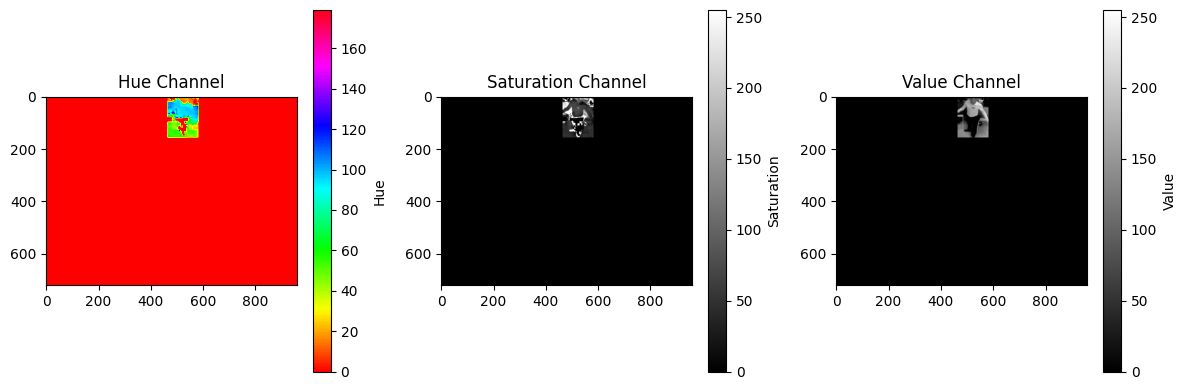

In [ ]:
# Plot the HSV value of image

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('/content/sample_000379_254.png')  # Replace with the path to your image

# Convert the image to the HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Split the HSV image into separate channels
hue_channel = hsv_image[:, :, 0]
saturation_channel = hsv_image[:, :, 1]
value_channel = hsv_image[:, :, 2]

# Display the hue, saturation, and value channels
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Display hue channel with color bar
hue_img = axs[0].imshow(hue_channel, cmap='hsv', vmin=0, vmax=179)
axs[0].set_title('Hue Channel')
cbar1 = plt.colorbar(hue_img, ax=axs[0])
cbar1.set_label('Hue')

# Display saturation channel with color bar
saturation_img = axs[1].imshow(saturation_channel, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Saturation Channel')
cbar2 = plt.colorbar(saturation_img, ax=axs[1])
cbar2.set_label('Saturation')

# Display value channel with color bar
value_img = axs[2].imshow(value_channel, cmap='gray', vmin=0, vmax=255)
axs[2].set_title('Value Channel')
cbar3 = plt.colorbar(value_img, ax=axs[2])
cbar3.set_label('Value')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Load the image
image = plt.imread("/content/ROI /sample_000200_106.png")

# Define the coordinates
x = 735
y = 371

# Plot the coordinate on the image
plt.imshow(image)
plt.scatter(x, y, color='red', s=10)
plt.show()